In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# 커널다운 방지. 
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#모델저장 
from tensorflow.keras.models import save_model

In [2]:
#변수설정 # gpu사용 변수
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
df = pd.read_csv("C:/Users/shj06/DL_data_for/DL/Data/fer2013/fer2013.csv")

In [5]:
# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))

In [6]:
# train test split
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [7]:
# # 데이터프레임에서 train 및 test 데이터를 분할
# train_data = df[df['Usage'] == 'Training']
# test_data = df[df['Usage'] == 'PublicTest']

# # train 및 test 데이터를 CSV 파일로 저장해주는 코드인데 한번만 해도되서 주석처리 
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

In [8]:
#data set array구조 reshape
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [9]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [10]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 255
test_data /= 255

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


In [11]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))

In [12]:
#fer2013 data확인 

Text(0.5, 1.0, 'Ground Truth : happy')

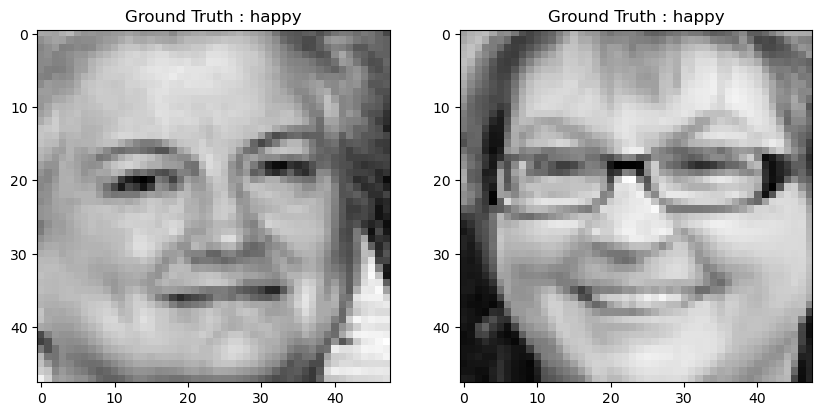

In [13]:
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100
plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

In [14]:
#face dectection pretrained model
# opencv의 cascade 사용

In [15]:
def detect_face(frame):
    
    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )
    
    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])
            
    return gray, detected_faces, coord

In [16]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:
        
        # 얼굴로 감지된 영역
        x, y, w, h = det
        
        # 이미지 경계값 받기
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        
        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
        
        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)
        
    return new_face

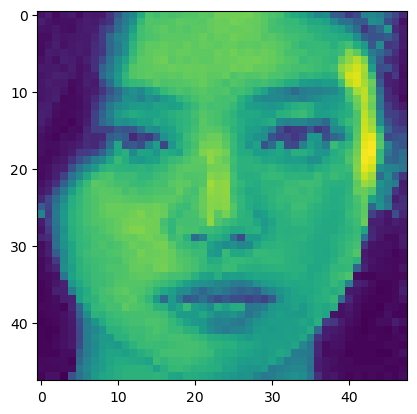

In [17]:
jen = cv2.imread("C:\\Users\\shj06\\DL_data_for\\jen.jpg")
plt.imshow(cv2.cvtColor(jen, cv2.COLOR_BGR2RGB))

# 얼굴 찾기
gray, detected_faces, coord = detect_face(jen)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features(gray, detected_faces, coord)

# 시각화
plt.imshow(face_zoom[0])

In [29]:
#감정분석 모델 라인 

In [19]:
def cnn_model():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    
    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))
    
    return model

In [20]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

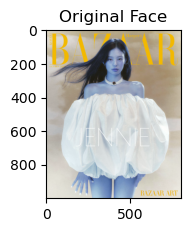

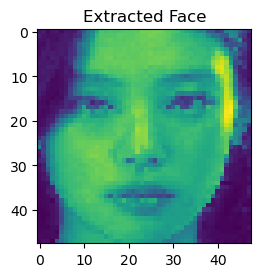

In [21]:
# 각 레이어마다 어떻게 변화하는지 시각화

# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기 
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 시각화 할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)
    

jenny = cv2.imread("C:\\Users\\shj06\\DL_data_for\\jen.jpg")
gray, detected_faces, coord = detect_face(jenny)
face_zoom = extract_face_features(gray, detected_faces, coord)
face = face_zoom[0]

plt.subplot(211)
plt.title("Original Face")
plt.imshow(jenny)
plt.subplots(constrained_layout=True) #각 subplot간격 조정 (최적)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

In [22]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 랜덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기
                              
# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/100
113/113 [==============================] - 114s 990ms/step - loss: 1.8126 - accuracy: 0.2481 - val_loss: 1.7837 - val_accuracy: 0.2508
Epoch 2/100
113/113 [==============================] - 130s 1s/step - loss: 1.7693 - accuracy: 0.2615 - val_loss: 1.7058 - val_accuracy: 0.3422
Epoch 3/100
113/113 [==============================] - 126s 1s/step - loss: 1.7069 - accuracy: 0.3123 - val_loss: 1.5793 - val_accuracy: 0.3918
Epoch 4/100
113/113 [==============================] - 136s 1s/step - loss: 1.6267 - accuracy: 0.3570 - val_loss: 1.4952 - val_accuracy: 0.4076
Epoch 5/100
113/113 [==============================] - 118s 1s/step - loss: 1.5589 - accuracy: 0.3942 - val_loss: 1.4031 - val_accuracy: 0.4673
Epoch 6/100
113/113 [==============================] - 129s 1s/step - loss: 1.4859 - accuracy: 0.4239 - val_loss: 1.3314 - val_accuracy: 0.4873
Epoch 7/100
113/113 [==============================] - 144s 1s/step - loss: 1.4276 - accuracy: 0.4451 - val_loss: 1.2851 - val_accura

In [ ]:
#모델 평가 

Text(0.5, 1.0, 'Accuracy Curves')

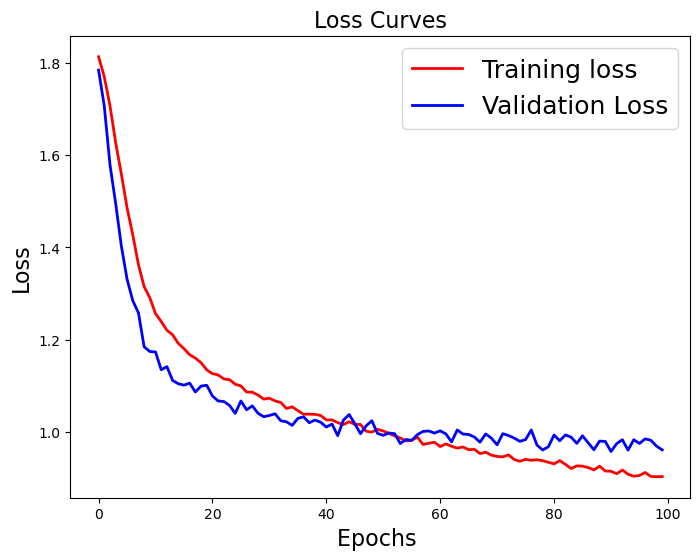

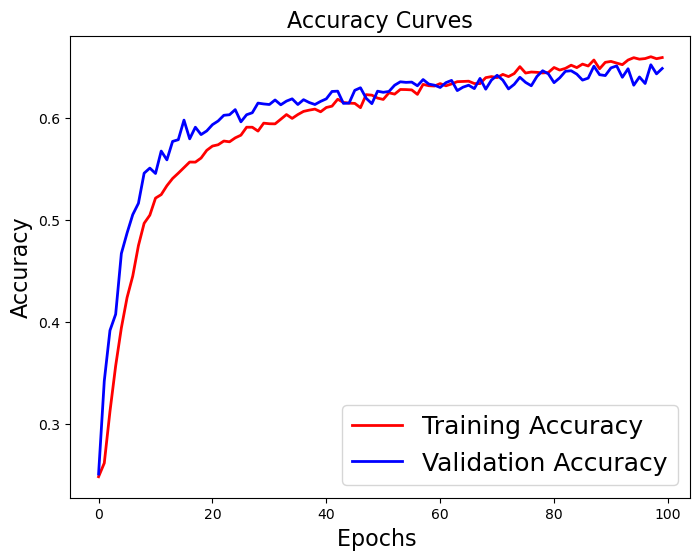

In [23]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#감성분석 모델 결과 체크 !

1/1 [==============================] - 1s 1s/step


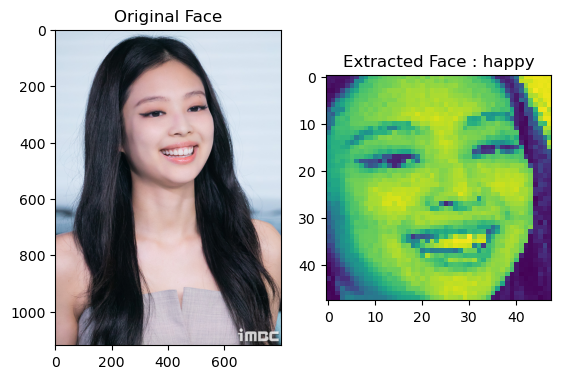

In [24]:
# 원본이미지 확인
face = cv2.imread("C:\\Users\\shj06\\DL_data_for\\smile_jen.jpeg")

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

In [25]:
# 모델 저장
model.save('model_emotion_prediction.h5')